# Deep Finance Researcher with TODO Planner

Build an intelligent agent with task planning capabilities that can search financial documents (RAG) and live market data.

## Setup

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.agents.middleware import TodoListMiddleware, SummarizationMiddleware
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

from scripts.rag_tools import hybrid_search, live_finance_researcher
from scripts.prompts import MULTIMODEL_AGENT_PROMPT
from scripts.agent_utils import stream_agent_response

## Initialize Components

In [ ]:
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

## Create Agent with TODO Planner and Summarization

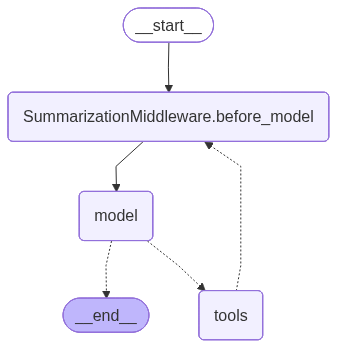

In [19]:
def get_agent():

    conn = sqlite3.connect("data/todo_financial_rag_agent.db", check_same_thread=False)
    checkpointer = SqliteSaver(conn=conn)

    agent = create_agent(
        model=model,
        tools=[hybrid_search, live_finance_researcher],
        system_prompt=MULTIMODEL_AGENT_PROMPT,
        checkpointer=checkpointer,
        middleware=[
            SummarizationMiddleware(
                model=ChatGoogleGenerativeAI(model='gemini-3-flash-preview'),
                trigger=[("messages", 25)],
                keep=("messages", 10)
            ),
            TodoListMiddleware()
        ]
    )

    return agent

agent = get_agent()
agent

## Examples

In [15]:
# Historical data query
stream_agent_response(agent, "What was Amazon's revenue in Q1 2024?", thread_id="session_1")


  Tool Called: hybrid_search
   Args: {'query': 'Amazon Q1 2024 revenue'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q1', 'fiscal_year': '2024', 'company_name': 'amazon', 'doc_type': '10-q'}


  Tool Result (length: 23950 chars)

In the first quarter (Q1) of 2024, Amazon's consolidated net sales (revenue) were **$143.31 billion** ($143,313 million). This represents a **13% increase** compared to the $127.36 billion reported in the same period of 2023.

### Segment Breakdown
The revenue was distributed across its three main operating segments as follows:

| Segment | Q1 2024 Revenue (in millions) | Year-over-Year Growth |
| :--- | :--- | :--- |
| **North America** | $86,341 | 12% |
| **International** | $31,935 | 10% |
| **AWS (Cloud)** | $25,037 | 17% |
| **Consolidated Total** | **$143,313** | **13%** |

### Key Highlights
*   **AWS Growth:** Amazon Web Services (AWS) saw a significant sales increase of 17% year-over-year, driven primarily by increased customer usage

In [16]:
# Live market data
stream_agent_response(agent, "What is the current stock price of Apple (AAPL) and latest news?", thread_id="session_2")


  Tool Called: live_finance_researcher
   Args: {'query': 'Apple (AAPL) current stock price and latest news'}


  Tool Result (length: 1894 chars)

As of the latest market update, Apple Inc. (AAPL) is trading at **$272.19 USD**.

### **Latest News for Apple (AAPL):**

*   **New Developer Terms:** Apple has updated its developer agreement, allowing the company to collect outstanding debts from developers at any time.
*   **Expansion of App Store Advertising:** Reports indicate that Apple plans to increase the number of advertisements within App Store search results starting next year.
*   **Regulatory Changes in Japan:** Following new local regulations, Apple is loosening its control over the iOS ecosystem in Japan, opening up opportunities for alternative app stores and payment systems.
*   **Strong Buyback Performance:** Apple continues to lead in shareholder returns, being cited as one of the top companies for stock buybacks in Q3 2024.
*   **Long-term Outlook:** Market analysts are

In [17]:
# Complex query with TODO planning
stream_agent_response(
    agent, 
    "Compare Microsoft's Q2 2024 revenue from SEC filings with its current stock performance",
    thread_id="session_3"
)


  Tool Called: write_todos
   Args: {'todos': [{'status': 'in_progress', 'content': "Search for Microsoft's Q2 2024 revenue in SEC filings"}, {'status': 'pending', 'content': "Get Microsoft's current stock performance from Yahoo Finance"}, {'status': 'pending', 'content': 'Compare revenue data with stock performance and summarize findings'}]}


  Tool Called: hybrid_search
   Args: {'query': 'Microsoft Q2 2024 revenue SEC filing 10-Q'}


  Tool Result (length: 318 chars)


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q2', 'fiscal_year': '2024', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Microsoft revenue quarter ended December 31 2023'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_quarter': 'q4', 'fiscal_year': '2023', 'company_name': 'microsoft', 'doc_type': '10-q'}


  Tool Result (length: 0 chars)


  Tool Called: hybrid_search
   Args: {'query': 'MSFT revenue 2024'}


  Tool

In [18]:
# Multi-company analysis
stream_agent_response(
    agent, 
    "Compare the profitability of Amazon and Google in 2023 and show results in a table",
    thread_id="session_4"
)


  Tool Called: write_todos
   Args: {'todos': [{'status': 'in_progress', 'content': "Search for Amazon's 2023 financial results (Revenue, Operating Income, Net Income)"}, {'status': 'pending', 'content': "Search for Google's (Alphabet) 2023 financial results (Revenue, Operating Income, Net Income)"}, {'status': 'pending', 'content': 'Compare profitability metrics and create the final table with citations'}]}


  Tool Result (length: 385 chars)


  Tool Called: hybrid_search
   Args: {'query': 'Amazon 2023 annual financial results revenue operating income net income'}


  Tool Called: ChunkMetadata
   Args: {'fiscal_year': '2023', 'company_name': 'amazon', 'doc_type': '10-k'}


  Tool Result (length: 22677 chars)


  Tool Called: write_todos
   Args: {'todos': [{'status': 'completed', 'content': "Search for Amazon's 2023 financial results (Revenue, Operating Income, Net Income)"}, {'status': 'in_progress', 'content': "Search for Google's (Alphabet) 2023 financial results (Revenue, Oper